## Model building with ReNET50 with Place 365 weights

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# Import basic libraries
import matplotlib.pyplot as plt
import numpy as np
import os,shutil

# Fastai reloads
%reload_ext autoreload
%autoreload 2
%matplotlib inline

#Impost fastai
from fastai.vision import *
from fastai.metrics import error_rate,accuracy
from fastai.callbacks import *
from fastai.imports import *
from fastai.callbacks.mem import PeakMemMetric

from pathlib import Path

#from torchvision.models import *
#from torch.nn import CrossEntropyLoss

import torchvision
import torch
from collections import OrderedDict

import cv2
#import pretrainedmodels

from sklearn.metrics import accuracy_score,f1_score,confusion_matrix,classification_report
import seaborn as sns

In [3]:
PATH=Path('data/')

## Create Data block (Try with half size)

In [4]:
tfms=get_transforms(max_rotate=20,max_zoom=1.3,p_lighting=.8,
                    xtra_tfms=[cutout(n_holes=(1,4), length=(5, 10), p=.75), jitter(magnitude=0.005, p=.25)])

In [5]:
img=open_image(PATH/'train_resized'/os.listdir(PATH/'train_resized')[1])

In [6]:
img.shape

torch.Size([3, 150, 210])

In [7]:
src_size=np.array(img.shape[1:]);src_size

array([150, 210])

In [8]:
np.random.seed(42)
src = (ImageList.from_csv(PATH, 'train.csv', folder='train_resized')
       .split_by_rand_pct(0.2)
       .label_from_df(label_delim=' ')
      .add_test_folder('test_resized'))

In [9]:
data = (src.transform(tfms, size=src_size//2)
        .databunch(bs=256).normalize(imagenet_stats))

In [10]:
data.classes

['1', '2', '3', '4', '5']

In [12]:
data

ImageDataBunch;

Train: LabelList (5002 items)
x: ImageList
Image (3, 75, 105),Image (3, 75, 105),Image (3, 75, 105),Image (3, 75, 105),Image (3, 75, 105)
y: MultiCategoryList
1,1,2,3,2
Path: data;

Valid: LabelList (1250 items)
x: ImageList
Image (3, 75, 105),Image (3, 75, 105),Image (3, 75, 105),Image (3, 75, 105),Image (3, 75, 105)
y: MultiCategoryList
4,1,1,3,4
Path: data;

Test: LabelList (2680 items)
x: ImageList
Image (3, 75, 105),Image (3, 75, 105),Image (3, 75, 105),Image (3, 75, 105),Image (3, 75, 105)
y: EmptyLabelList
,,,,
Path: data

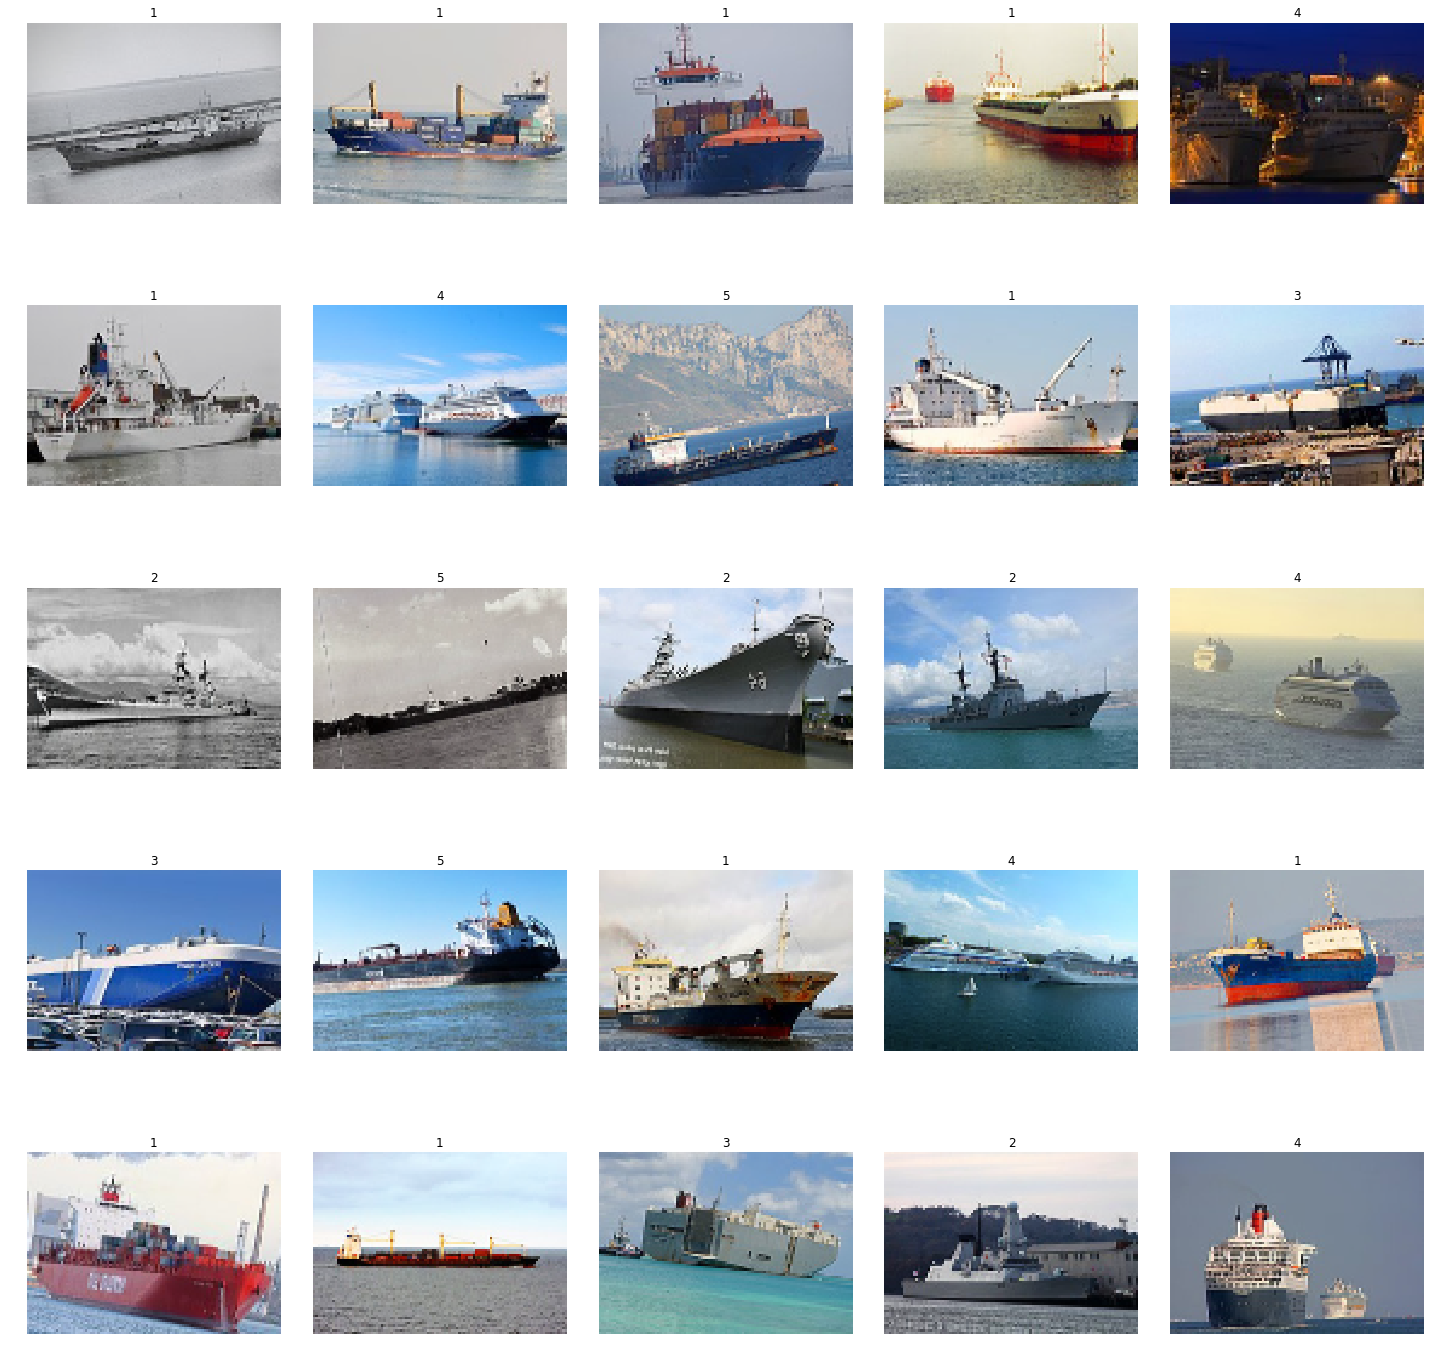

In [91]:
data.show_batch()

## Try with ResNET 50 with Places 365 weights

In [64]:
! wget http://places2.csail.mit.edu/models_places365/resnet50_places365.pth.tar -P data/models/

--2019-06-03 10:38:39--  http://places2.csail.mit.edu/models_places365/resnet50_places365.pth.tar
Resolving places2.csail.mit.edu (places2.csail.mit.edu)... 128.30.100.255
Connecting to places2.csail.mit.edu (places2.csail.mit.edu)|128.30.100.255|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 97270159 (93M) [application/x-tar]
Saving to: ‘data/models/resnet50_places365.pth.tar.1’

resnet50_places365. 100%[===================>]  92.76M  10.4MB/s    in 11s     

2019-06-03 10:38:51 (8.20 MB/s) - ‘data/models/resnet50_places365.pth.tar.1’ saved [97270159/97270159]



In [ ]:
!ls 

In [10]:
metrics_custom=[fbeta,accuracy_thresh]

In [11]:
def places_resnet50(f=None):
    import torchvision.models as models
    model = models.__dict__['resnet50'](num_classes=365)
    checkpoint = torch.load('data/models/resnet50_places365.pth.tar', map_location=lambda storage, loc: storage)
    state_dict = {str.replace(k,'module.',''): v for k,v in checkpoint['state_dict'].items()}
    model.load_state_dict(state_dict)
    model.eval()
    return model

def getLearner(data):
    learn1 = cnn_learner(data, places_resnet50, metrics=metrics_custom)
    return learn1

In [12]:
learn=getLearner(data)

In [14]:
stage1_places_resnet50_call_back=[CSVLogger(learn=learn, filename='places_resnet50-stage1-history'), ShowGraph(learn=learn),
                       EarlyStoppingCallback(learn=learn,monitor='fbeta', min_delta=0.001, patience=10),
                          SaveModelCallback(learn,monitor='fbeta', mode='max',name='places_resnet50_best_stage-1-aug'),
                          PeakMemMetric(learn)]

In [23]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


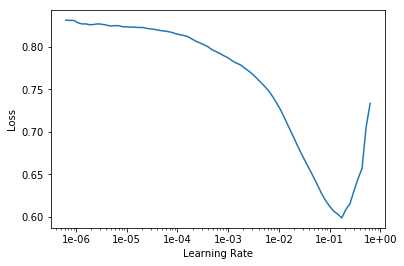

In [24]:
learn.recorder.plot()

In [15]:
lr=2e-2

epoch,train_loss,valid_loss,fbeta,accuracy_thresh,cpu used,peak,gpu used,peak,time
0,0.688799,0.539123,0.595071,0.745280,0,0,160,11650,00:08
1,0.574179,0.350520,0.731092,0.860480,0,0,0,4266,00:06
2,0.462344,0.297332,0.756229,0.874880,0,0,0,4266,00:05
3,0.389787,0.257681,0.795986,0.886720,0,0,0,4266,00:05
4,0.337039,0.219627,0.828438,0.906080,0,0,0,4266,00:05
5,0.297168,0.200115,0.842552,0.913920,0,0,0,4266,00:05
6,0.263788,0.205251,0.848591,0.914560,0,0,0,4266,00:05
7,0.237113,0.186507,0.857910,0.923040,0,0,0,4266,00:05
8,0.214116,0.179079,0.866171,0.925280,0,0,0,4266,00:05
9,0.195673,0.173452,0.865676,0.927360,0,0,0,4266,00:05


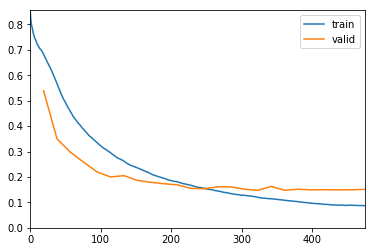

Better model found at epoch 0 with fbeta value: 0.5950714349746704.
Better model found at epoch 1 with fbeta value: 0.7310920357704163.
Better model found at epoch 2 with fbeta value: 0.7562286257743835.
Better model found at epoch 3 with fbeta value: 0.7959856986999512.
Better model found at epoch 4 with fbeta value: 0.8284381031990051.
Better model found at epoch 5 with fbeta value: 0.8425524234771729.
Better model found at epoch 6 with fbeta value: 0.8485905528068542.
Better model found at epoch 7 with fbeta value: 0.8579095602035522.
Better model found at epoch 8 with fbeta value: 0.8661714792251587.
Better model found at epoch 10 with fbeta value: 0.8676953315734863.
Better model found at epoch 11 with fbeta value: 0.8843047618865967.
Better model found at epoch 14 with fbeta value: 0.8854857683181763.
Better model found at epoch 15 with fbeta value: 0.8857143521308899.
Better model found at epoch 16 with fbeta value: 0.8901333212852478.
Better model found at epoch 18 with fbeta v

AttributeError: 'NoneType' object has no attribute 'mixup'

In [16]:
learn.fit_one_cycle(25,slice(lr),callbacks=stage1_places_resnet50_call_back,wd=0.1).mixup().to_f16()

In [17]:
learn.unfreeze()

In [18]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


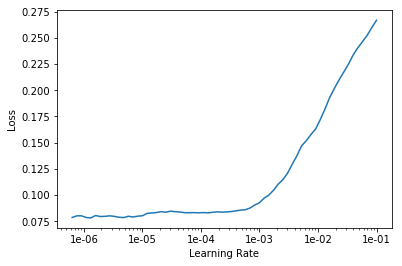

In [19]:
learn.recorder.plot()

In [22]:
lr=3e-6

In [20]:
stage2_places_resnet50_call_back=[CSVLogger(learn=learn, filename='places_resnet50-stage2-history'), ShowGraph(learn=learn),
                       EarlyStoppingCallback(learn=learn,monitor='fbeta', min_delta=0.001, patience=10),
                          SaveModelCallback(learn,monitor='fbeta', mode='max',name='places_resnet50_best_stage-2-aug'),
                          PeakMemMetric(learn)]

In [25]:
learn.load('places_resnet50_best_stage-1-aug')

Learner(data=ImageDataBunch;

Train: LabelList (5002 items)
x: ImageList
Image (3, 75, 105),Image (3, 75, 105),Image (3, 75, 105),Image (3, 75, 105),Image (3, 75, 105)
y: MultiCategoryList
1,1,2,3,2
Path: data;

Valid: LabelList (1250 items)
x: ImageList
Image (3, 75, 105),Image (3, 75, 105),Image (3, 75, 105),Image (3, 75, 105),Image (3, 75, 105)
y: MultiCategoryList
4,1,1,3,4
Path: data;

Test: LabelList (2680 items)
x: ImageList
Image (3, 75, 105),Image (3, 75, 105),Image (3, 75, 105),Image (3, 75, 105),Image (3, 75, 105)
y: EmptyLabelList
,,,,
Path: data, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias

epoch,train_loss,valid_loss,fbeta,accuracy_thresh,cpu used,peak,gpu used,peak,time
0,0.084653,0.145106,0.896743,0.946880,0,0,1108,3380,00:06
1,0.085605,0.165259,0.883943,0.944640,0,0,0,3552,00:07
2,0.090968,0.179326,0.881981,0.942240,0,0,0,3552,00:06
3,0.096141,0.151408,0.889219,0.946400,0,0,0,3552,00:05
4,0.100091,0.158097,0.890114,0.943680,0,0,0,3552,00:05
5,0.098056,0.154098,0.894024,0.948000,0,0,0,3552,00:06
6,0.094109,0.156798,0.891238,0.946080,0,0,0,3552,00:06
7,0.091924,0.155483,0.890629,0.945600,0,0,0,3552,00:06
8,0.089835,0.152209,0.892457,0.946560,0,0,0,3552,00:06
9,0.089288,0.151117,0.894095,0.948480,0,0,0,3552,00:06


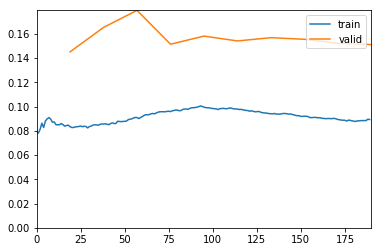

Better model found at epoch 0 with fbeta value: 0.8967428803443909.


AttributeError: 'NoneType' object has no attribute 'mixup'

In [24]:
learn.fit_one_cycle(10,slice(lr,2e-2),callbacks=stage2_places_resnet50_call_back,wd=0.1).mixup().to_f16()

## Pass full size image

In [13]:
data = (src.transform(tfms, size=src_size)
        .databunch(bs=128).normalize(imagenet_stats))

In [27]:
learn=learn.load('places_resnet50_best_stage-1-aug')

In [28]:
model_summary(learn)

Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 75, 105]        9,408      True      
______________________________________________________________________
BatchNorm2d          [64, 75, 105]        128        True      
______________________________________________________________________
ReLU                 [64, 75, 105]        0          False     
______________________________________________________________________
MaxPool2d            [64, 38, 53]         0          False     
______________________________________________________________________
Conv2d               [64, 38, 53]         4,096      True      
______________________________________________________________________
BatchNorm2d          [64, 38, 53]         128        True      
______________________________________________________________________
Conv2d               [64, 38, 53]         36,864     True      
______________________________________________________________

In [29]:
learn.freeze()

In [30]:
model_summary(learn)

Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 75, 105]        9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 75, 105]        128        True      
______________________________________________________________________
ReLU                 [64, 75, 105]        0          False     
______________________________________________________________________
MaxPool2d            [64, 38, 53]         0          False     
______________________________________________________________________
Conv2d               [64, 38, 53]         4,096      False     
______________________________________________________________________
BatchNorm2d          [64, 38, 53]         128        True      
______________________________________________________________________
Conv2d               [64, 38, 53]         36,864     False     
______________________________________________________________

In [14]:
learn.data=data

In [15]:
learn.data

ImageDataBunch;

Train: LabelList (5002 items)
x: ImageList
Image (3, 150, 210),Image (3, 150, 210),Image (3, 150, 210),Image (3, 150, 210),Image (3, 150, 210)
y: MultiCategoryList
1,1,2,3,2
Path: data;

Valid: LabelList (1250 items)
x: ImageList
Image (3, 150, 210),Image (3, 150, 210),Image (3, 150, 210),Image (3, 150, 210),Image (3, 150, 210)
y: MultiCategoryList
4,1,1,3,4
Path: data;

Test: LabelList (2680 items)
x: ImageList
Image (3, 150, 210),Image (3, 150, 210),Image (3, 150, 210),Image (3, 150, 210),Image (3, 150, 210)
y: EmptyLabelList
,,,,
Path: data

In [38]:
learn.metrics

[<function fastai.metrics.fbeta(y_pred:torch.Tensor, y_true:torch.Tensor, thresh:float=0.2, beta:float=2, eps:float=1e-09, sigmoid:bool=True) -> <function NewType.<locals>.new_type at 0x7fe3ff0ffea0>>,
 <function fastai.metrics.accuracy_thresh(y_pred:torch.Tensor, y_true:torch.Tensor, thresh:float=0.5, sigmoid:bool=True) -> <function NewType.<locals>.new_type at 0x7fe3ff0ffea0>>]

In [33]:
stage3_places_resnet50_call_back=[CSVLogger(learn=learn, filename='places_resnet50-stage3-history'), ShowGraph(learn=learn),
                       EarlyStoppingCallback(learn=learn,monitor='fbeta', min_delta=0.001, patience=10),
                          SaveModelCallback(learn,monitor='fbeta', mode='max',name='places_resnet50_best_stage-3-aug'),
                          PeakMemMetric(learn)]

In [34]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


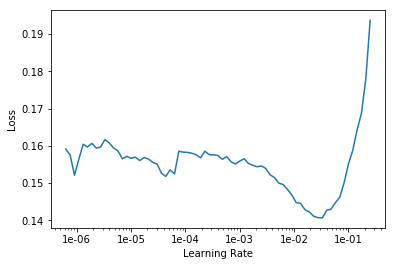

In [35]:
learn.recorder.plot()

In [36]:
lr=4e-3

epoch,train_loss,valid_loss,fbeta,accuracy_thresh,cpu used,peak,gpu used,peak,time
0,0.150062,0.159077,0.872419,0.933280,0,0,66,9954,00:12
1,0.134679,0.135028,0.893543,0.943360,0,0,66,7466,00:11
2,0.120092,0.122610,0.903771,0.949280,0,0,-68,7470,00:11
3,0.109541,0.123184,0.910857,0.950560,0,0,2,7530,00:11
4,0.100457,0.138161,0.900743,0.950080,0,0,66,7466,00:11
5,0.090101,0.101313,0.922686,0.961120,0,0,-68,7470,00:11
6,0.081878,0.104187,0.918381,0.958560,0,0,2,7530,00:11
7,0.075088,0.100776,0.921886,0.961280,0,0,66,7466,00:11
8,0.069406,0.094133,0.927638,0.963360,0,0,-68,7470,00:11
9,0.064624,0.098195,0.924800,0.961120,0,0,2,7530,00:11


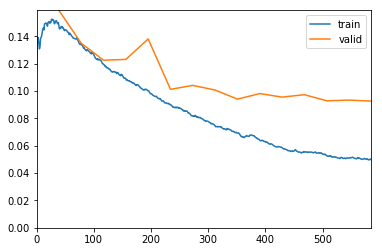

Better model found at epoch 0 with fbeta value: 0.8724190592765808.
Better model found at epoch 1 with fbeta value: 0.8935428857803345.
Better model found at epoch 2 with fbeta value: 0.9037714600563049.
Better model found at epoch 3 with fbeta value: 0.9108572006225586.
Better model found at epoch 5 with fbeta value: 0.9226857423782349.
Better model found at epoch 8 with fbeta value: 0.9276381134986877.
Better model found at epoch 11 with fbeta value: 0.9281143546104431.
Better model found at epoch 12 with fbeta value: 0.9313715100288391.
Better model found at epoch 14 with fbeta value: 0.9327428936958313.


AttributeError: 'NoneType' object has no attribute 'mixup'

In [38]:
learn.fit_one_cycle(15,slice(lr),callbacks=stage3_places_resnet50_call_back,wd=0.1).mixup().to_f16()

In [23]:
learn.load('places_resnet50_best_stage-3-aug')

Learner(data=ImageDataBunch;

Train: LabelList (5002 items)
x: ImageList
Image (3, 150, 210),Image (3, 150, 210),Image (3, 150, 210),Image (3, 150, 210),Image (3, 150, 210)
y: MultiCategoryList
1,1,2,3,2
Path: data;

Valid: LabelList (1250 items)
x: ImageList
Image (3, 150, 210),Image (3, 150, 210),Image (3, 150, 210),Image (3, 150, 210),Image (3, 150, 210)
y: MultiCategoryList
4,1,1,3,4
Path: data;

Test: LabelList (2680 items)
x: ImageList
Image (3, 150, 210),Image (3, 150, 210),Image (3, 150, 210),Image (3, 150, 210),Image (3, 150, 210)
y: EmptyLabelList
,,,,
Path: data, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stri

In [24]:
learn.unfreeze()

In [25]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


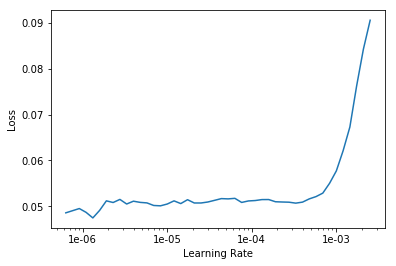

In [26]:
learn.recorder.plot()

In [27]:
lr=1e-7

In [28]:
stage4_places_resnet50_call_back=[CSVLogger(learn=learn, filename='places_resnet50-stage4-history'), ShowGraph(learn=learn),
                       EarlyStoppingCallback(learn=learn,monitor='fbeta', min_delta=0.001, patience=10),
                          SaveModelCallback(learn,monitor='fbeta', mode='max',name='places_resnet50_best_stage-4-aug'),
                          PeakMemMetric(learn)]

epoch,train_loss,valid_loss,fbeta,accuracy_thresh,cpu used,peak,gpu used,peak,time
0,0.048619,0.092484,0.931981,0.964800,0,0,3506,4206,00:14
1,0.047458,0.093250,0.931410,0.964000,0,0,0,7558,00:14
2,0.046541,0.093470,0.930686,0.965440,0,0,0,7558,00:14
3,0.050731,0.092926,0.931010,0.964640,0,0,0,7558,00:14
4,0.050587,0.092812,0.930838,0.964320,0,0,0,7558,00:14
5,0.049310,0.094363,0.932876,0.964800,0,0,0,7558,00:14
6,0.047553,0.094020,0.931943,0.965440,0,0,0,7558,00:14
7,0.047698,0.092518,0.931276,0.965440,0,0,0,7558,00:14
8,0.049180,0.091120,0.933276,0.965760,0,0,0,7558,00:14
9,0.047615,0.091525,0.930038,0.965600,0,0,0,7558,00:14


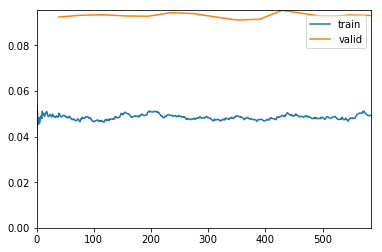

Better model found at epoch 0 with fbeta value: 0.9319809675216675.
Better model found at epoch 5 with fbeta value: 0.9328762888908386.
Better model found at epoch 8 with fbeta value: 0.9332761764526367.


AttributeError: 'NoneType' object has no attribute 'mixup'

In [29]:
learn.fit_one_cycle(15,slice(lr),callbacks=stage4_places_resnet50_call_back,wd=0.1).mixup().to_f16()

In [13]:
learn.load('places_resnet50_best_stage-4-aug')

Learner(data=ImageDataBunch;

Train: LabelList (5002 items)
x: ImageList
Image (3, 75, 105),Image (3, 75, 105),Image (3, 75, 105),Image (3, 75, 105),Image (3, 75, 105)
y: MultiCategoryList
1,1,2,3,2
Path: data;

Valid: LabelList (1250 items)
x: ImageList
Image (3, 75, 105),Image (3, 75, 105),Image (3, 75, 105),Image (3, 75, 105),Image (3, 75, 105)
y: MultiCategoryList
4,1,1,3,4
Path: data;

Test: LabelList (2680 items)
x: ImageList
Image (3, 75, 105),Image (3, 75, 105),Image (3, 75, 105),Image (3, 75, 105),Image (3, 75, 105)
y: EmptyLabelList
,,,,
Path: data, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias

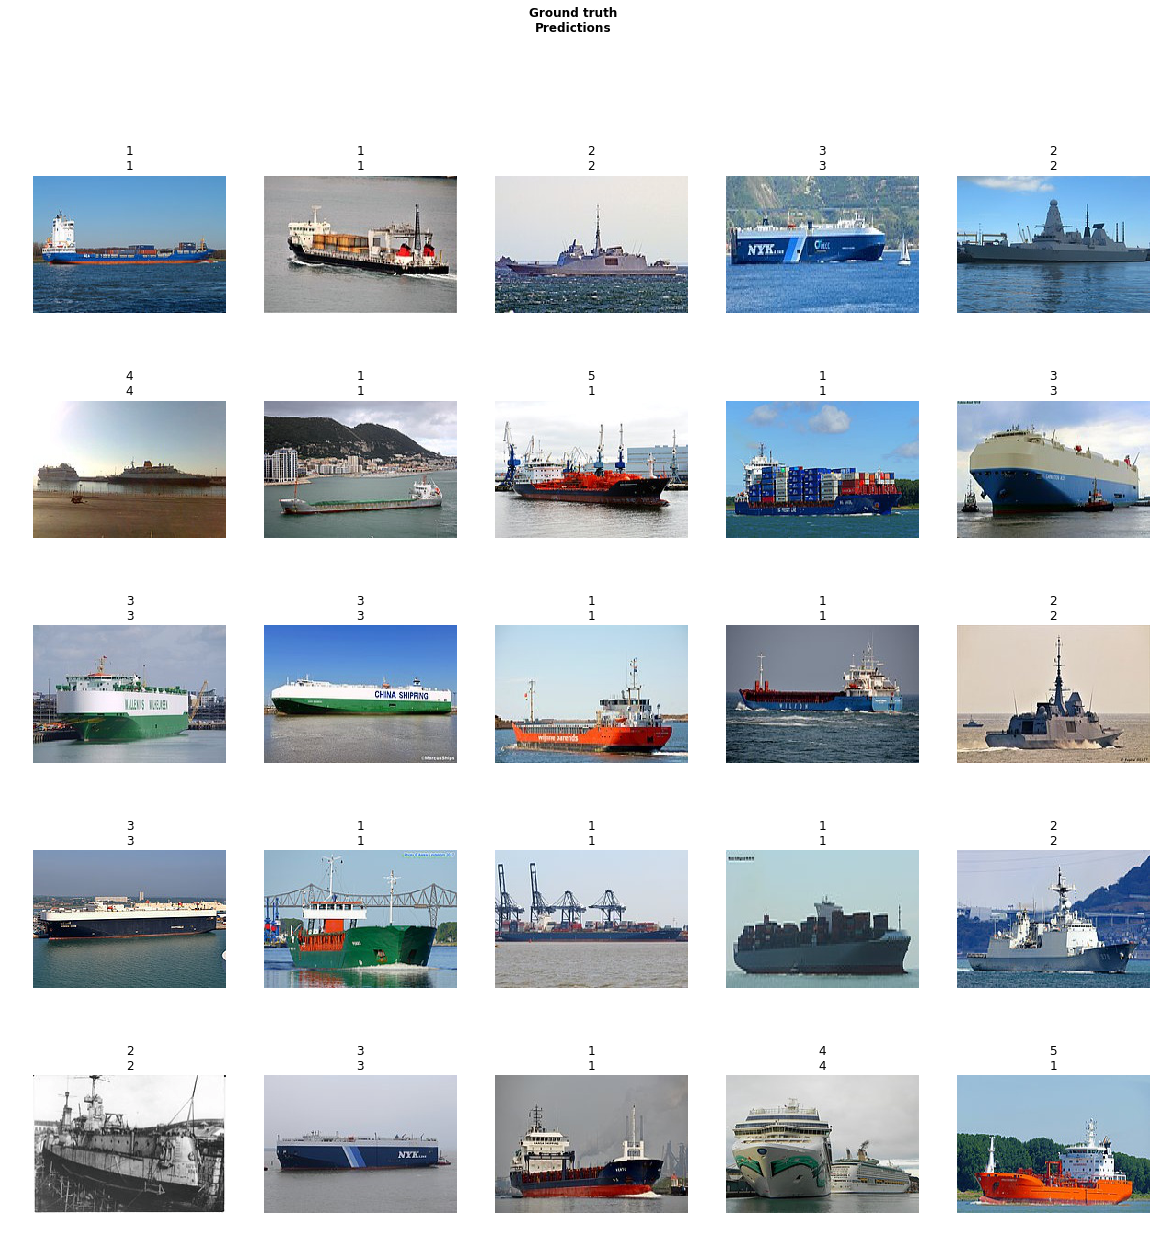

In [31]:
learn.show_results(3)

In [34]:
interp=ClassificationInterpretation.from_learner(learn,ds_type=DatasetType.Valid)

In [32]:
data

ImageDataBunch;

Train: LabelList (5002 items)
x: ImageList
Image (3, 150, 210),Image (3, 150, 210),Image (3, 150, 210),Image (3, 150, 210),Image (3, 150, 210)
y: MultiCategoryList
1,1,2,3,2
Path: data;

Valid: LabelList (1250 items)
x: ImageList
Image (3, 150, 210),Image (3, 150, 210),Image (3, 150, 210),Image (3, 150, 210),Image (3, 150, 210)
y: MultiCategoryList
4,1,1,3,4
Path: data;

Test: LabelList (2680 items)
x: ImageList
Image (3, 150, 210),Image (3, 150, 210),Image (3, 150, 210),Image (3, 150, 210),Image (3, 150, 210)
y: EmptyLabelList
,,,,
Path: data

In [35]:
losses,idxs = interp.top_losses()

In [36]:
len(data.valid_ds)==len(losses)==len(idxs)

False

In [153]:
pred_v,y,losses=learn.TTA(ds_type=DatasetType.Valid,with_loss=True)

In [37]:
test_pred_tta=learn.TTA(ds_type=DatasetType.Test)

In [38]:
test_pred_tta

(tensor([[9.9975e-01, 5.6372e-06, 6.3355e-05, 5.5906e-05, 8.0008e-05],
         [4.1579e-07, 6.5322e-04, 9.9978e-01, 2.4859e-05, 4.6357e-06],
         [3.6325e-01, 1.3004e-02, 2.2672e-03, 3.4993e-01, 1.2779e-01],
         ...,
         [5.0383e-02, 1.6114e-02, 8.8643e-01, 7.6581e-03, 5.3936e-03],
         [1.8236e-05, 9.9997e-01, 9.1674e-05, 3.7110e-05, 1.6610e-05],
         [9.9682e-01, 1.3526e-04, 2.6870e-04, 1.9722e-04, 1.6623e-03]]),
 tensor([0, 0, 0,  ..., 0, 0, 0]))

In [39]:
preds = np.argmax(test_pred_tta[0], 1)
preds

tensor([0, 2, 0,  ..., 2, 1, 0])

In [40]:
a=array(preds)

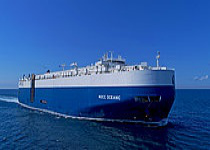

In [56]:
data.test_ds.x[1]

In [41]:
test_img_names = [Path(i).name for i in learn.data.test_ds.x.items]

In [42]:
submission = pd.DataFrame({'image': test_img_names, 'category': a+1})
submission.head(10)

,image,category
0,2904735.jpg,1
1,2890616.jpg,3
2,2902677.jpg,1
3,2741468.jpg,4
4,2802610.jpg,5
5,1630950.jpg,4
6,2882184.jpg,3
7,2787793.jpg,2
8,2866032.jpg,1
9,2369442.jpg,2


In [43]:
len(submission)

2680

In [44]:
submission.to_csv(PATH/'submission_places_resnet50.csv',index=False)

In [ ]:
## F1 score: 

## Merging validation data into training

In [14]:
np.random.seed(42)
src = (ImageList.from_csv(PATH, 'train.csv', folder='train_resized')
       .split_by_rand_pct(0)
       .label_from_df(label_delim=' ')
      .add_test_folder('test_resized'))

In [15]:
data = (src.transform(tfms, size=src_size)
        .databunch(bs=256).normalize(imagenet_stats))

In [16]:
data

ImageDataBunch;

Train: LabelList (6252 items)
x: ImageList
Image (3, 150, 210),Image (3, 150, 210),Image (3, 150, 210),Image (3, 150, 210),Image (3, 150, 210)
y: MultiCategoryList
1,1,2,3,2
Path: data;

Valid: LabelList (0 items)
x: ImageList

y: MultiCategoryList

Path: data;

Test: LabelList (2680 items)
x: ImageList
Image (3, 150, 210),Image (3, 150, 210),Image (3, 150, 210),Image (3, 150, 210),Image (3, 150, 210)
y: EmptyLabelList
,,,,
Path: data

In [17]:
learn.data=data

In [18]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


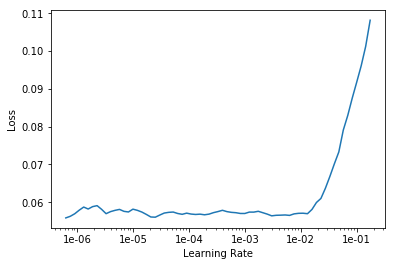

In [19]:
learn.recorder.plot()

In [20]:
lr=1e-3
learn.fit_one_cycle(10,max_lr=slice(lr),wd=0.1)

In [21]:
learn.save('resnet-50-places-noval')

In [22]:
test_img_names = [Path(i).name for i in learn.data.test_ds.x.items]
pred,y=learn.TTA(ds_type=DatasetType.Test)
preds = np.argmax(pred, 1)
a=array(preds)
submission = pd.DataFrame({'image': test_img_names, 'category': a+1})
submission.to_csv(PATH/'submission_places_resnet50_noval.csv',index=False)